# 사전작업

## 라이브러리 로드

In [106]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 150)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

## 데이터 로드

In [3]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 3min 40s


## train, test 합치기

In [5]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194754

## Get Date - AvSigVersion

In [6]:
datedict = np.load('./data/AvSigVersionTimestamps.npy')
datedict = datedict[()]
data['Date'] = data['AvSigVersion'].map(datedict)
data['Date_YMD'] = pd.to_datetime(data['Date'].astype(str).str.slice(0, 10))
del datedict

In [186]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

In [187]:
new_train = train.groupby(['Date_YMD']).HasDetections.agg(['size', 'mean'])
new_train.columns = ['size', 'target']
new_train = new_train.loc['2016-06-02':]

In [188]:
new_test = test.groupby(['Date_YMD']).HasDetections.agg(['size', 'mean'])
new_test.columns = ['size', 'target']
new_test = new_test.loc['2016-06-02':]

Train
* 2018-03-29 => 1
* 2018-07-23 => 2

Test
* 2018-05-29 => 1
* 2018-09-23 => 2

In [189]:
new_train.reset_index(inplace=True)

In [190]:
new_test.reset_index(inplace=True)

In [191]:
new_train['phase_1'] = (new_train.Date_YMD <= '2018-03-29') * 1
new_train['phase_2'] = ((new_train.Date_YMD > '2018-03-29') & (new_train.Date_YMD <= '2018-07-23')) * 1
new_train['phase_3'] = (new_train.Date_YMD > '2018-07-23') * 1

In [192]:
new_test['phase_1'] = (new_test.Date_YMD <= '2018-05-29') * 1
new_test['phase_2'] = ((new_test.Date_YMD > '2018-05-29') & (new_train.Date_YMD <= '2018-09-23')) * 1
new_test['phase_3'] = (new_test.Date_YMD > '2018-09-23') * 1

In [59]:
aggs = {}

In [66]:
from scipy import stats
def mode(x):
    return stats.mode(x)[0][0]

In [202]:
aggs['ProductName'] = ['nunique']
aggs['EngineVersion'] = ['nunique']
aggs['AppVersion'] = ['nunique']
aggs['AvSigVersion'] = ['nunique']
aggs['RtpStateBitfield'] = ['nunique', mode]
aggs['IsSxsPassiveMode'] = ['nunique', mode, 'mean']
aggs['AVProductStatesIdentifier'] = ['nunique', mode]
aggs['AVProductsInstalled'] = ['mean', 'max', 'min']
aggs['AVProductsEnabled'] = ['mean', 'max', 'min']
aggs['HasTpm'] = ['nunique', mode, 'mean']
aggs['CountryIdentifier'] = ['nunique', mode]
aggs['CityIdentifier'] = ['nunique', mode]
aggs['OrganizationIdentifier'] = ['nunique', mode]
aggs['GeoNameIdentifier'] = ['nunique', mode]
aggs['LocaleEnglishNameIdentifier'] = ['nunique', mode]
aggs['Platform'] = ['nunique']
aggs['Processor'] = ['nunique']

In [203]:
temp = train.groupby(['Date_YMD']).agg(aggs)

KeyboardInterrupt: 

In [ ]:
temp2 = test.groupby(['Date_YMD']).agg(aggs)

In [ ]:
cols = []
for i in range(temp.shape[1]):
    cols.append('col_' + str(i))

In [ ]:
temp.columns = cols

In [ ]:
temp = temp.reset_index()

In [ ]:
temp2.columns = cols

In [ ]:
temp2 = temp.reset_index()

In [ ]:
new_train = new_train.merge(temp, on='Date_YMD', how='left').set_index('Date_YMD')

In [ ]:
new_test = new_test.merge(temp2, on='Date_YMD', how='left').set_index('Date_YMD')

In [ ]:
fold = KFold(n_splits=3, shuffle=True, random_state=42)
counter = 0

In [ ]:
y_train = new_train.target

In [ ]:
del new_train['target']

In [ ]:
del new_test['target']

In [ ]:
new_train['size'] = np.around(new_train['size'] * 0.88)

In [ ]:
new_train

In [ ]:
print('\nLightGBM\n')

for train_index, test_index in fold.split(new_train):
    
    train_col = ['size', 'phase_1', 'phase_2', 'phase_3']
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = new_train.iloc[train_index][train_col]
    X_val = new_train.iloc[test_index][train_col]
    y_fit = y_train.iloc[train_index]
    y_val = y_train.iloc[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMRegressor(max_depth=-1,
                                   n_estimators=1000,
                                   learning_rate=0.01,
                                   num_leaves=2**5-1,
                                   objective='regression', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='rmse', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    counter += 1
    
    gc.collect()

In [173]:
time_idx = data.groupby(['Date_YMD']).size().index

In [134]:
temp = pd.DataFrame(time_idx)

In [146]:
temp = temp[temp.Date_YMD >= '2018-03-25']

In [142]:
lgb_model.predict(new_train.loc["2018-03-25":])

array([0.40074682, 0.40223608, 0.40200144, 0.40126105, 0.39496687,
       0.33588819, 0.32415147, 0.32931652, 0.33056866, 0.32359397,
       0.32446116, 0.32528368, 0.32948096, 0.31949921, 0.32996984,
       0.32172651, 0.3311498 , 0.32823746, 0.32583144, 0.32609381,
       0.32304636, 0.33056866, 0.31650358, 0.32056992, 0.32133991,
       0.32271388, 0.3208753 , 0.32948096, 0.31350972, 0.33056866,
       0.31966119, 0.32528368, 0.32247081, 0.32208299, 0.32297216,
       0.32869653, 0.31834707, 0.31059088, 0.31830282, 0.31499107,
       0.31870099, 0.32300857, 0.31583379, 0.31513903, 0.31169137,
       0.31296619, 0.3147233 , 0.32302901, 0.3098705 , 0.31565934,
       0.31059088, 0.31265482, 0.31573084, 0.30436546, 0.30609286,
       0.31643769, 0.31265482, 0.31218231, 0.31111274, 0.30954354,
       0.33107925, 0.32599132, 0.31294954, 0.31670012, 0.31334903,
       0.31109461, 0.3112261 , 0.31023195, 0.30927796, 0.31391364,
       0.30893503, 0.30559899, 0.30884683, 0.30559899, 0.31166

In [174]:
plt.plot(lgb_model.predict(new_train.loc["2018-03-25":]))

ValueError: Number of features of the model must match the input. Model n_features_ is 4 and input n_features is 36 

In [ ]:
new_test

In [177]:
new_test['target'] = lgb_model.predict(new_test.drop(['target'], axis=1)[train_col])

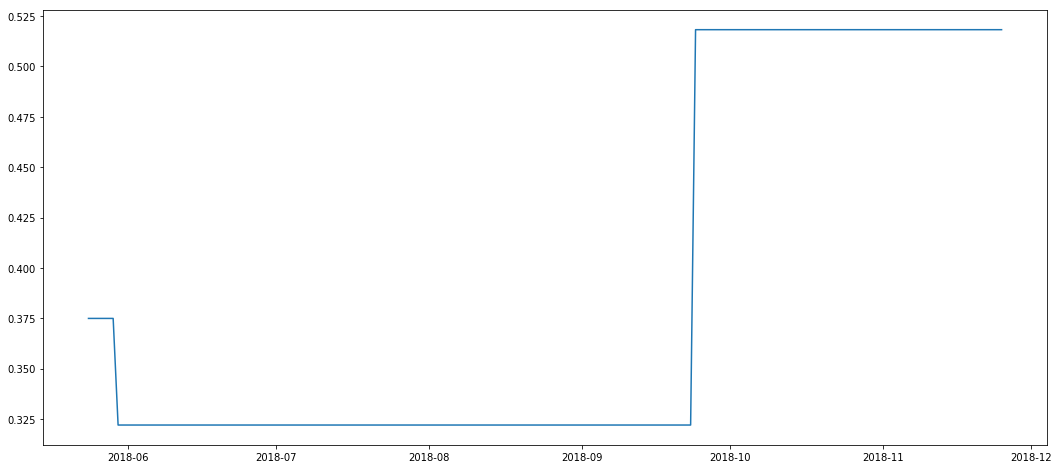

In [178]:
plt.figure(figsize=(18,8))
plt.plot(new_test.loc["2018-05-24":].target)